In [1]:
import pathlib

import numpy as np
import pandas as pd
import scipy.stats
import seaborn as sns

sns.set()

We begin by reading the data and summarizing the variables.

In [4]:
path = pathlib.Path.home() / 'data' / 'sleuth3' / 'case0602.csv'
df = pd.read_csv(path)
df.head()

,Proportion,Pair,Length
0,0.44,Pair1,35
1,0.54,Pair1,35
2,0.50,Pair1,35
3,0.65,Pair1,35
4,0.53,Pair1,35


In [5]:
summary = df.describe()
summary

,Proportion,Length
count,84.000000,84.000000
mean,0.621071,32.845238
std,0.153529,2.114175
min,0.100000,28.000000
25%,0.530000,31.000000
50%,0.615000,34.000000
75%,0.720000,34.000000
max,0.920000,35.000000


In [7]:
df.groupby('Pair')['Proportion'].describe()

,count,mean,std,min,25%,50%,75%,max
Pair,,,,,,,,
Pair1,16.0,0.563750,0.088610,0.44,0.4975,0.555,0.6275,0.73
Pair2,14.0,0.609286,0.124744,0.40,0.5275,0.645,0.6975,0.80
Pair3,17.0,0.624706,0.223386,0.10,0.5100,0.620,0.8400,0.91
Pair4,14.0,0.668571,0.142443,0.42,0.5725,0.680,0.7575,0.92
Pair5,9.0,0.641111,0.092256,0.48,0.6100,0.630,0.6600,0.78
Pair6,14.0,0.633571,0.178438,0.33,0.5650,0.625,0.7900,0.88


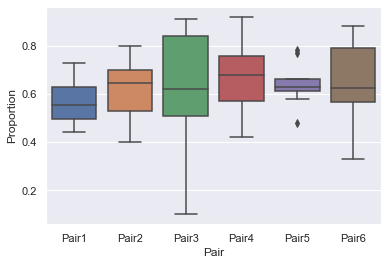

In [8]:
sns.boxplot(x='Pair', y='Proportion', data=df)

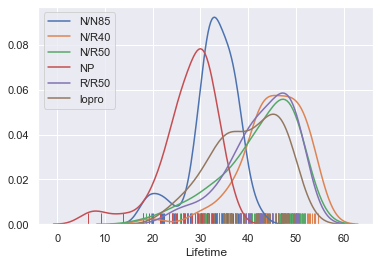

In [12]:
for diet, grp in df.groupby('Pair'):
    sns.distplot(grp['P'], rug=True, hist=False, label=diet)

Are the mice population lifetimes statistically different?  I.e.,

$\it{H_0}:  \mu_{N/N85} = \mu_{N/R40} = \mu_{N/R50} = \mu_{NP} = \mu_{R/R50} = \mu_{lopro}$

In [15]:
mu = summary.loc['mean', 'Lifetime']

a = np.empty((3, 5))
a[:] = NaN
index = ['Between Groups', 'Within Groups', 'Total']
columns = ['Sum of Squares', 'd.f.', 'Mean Square', 'F Statistic', 'p-value']
dfss = pd.DataFrame(a, columns=columns, index=index)

dfss.at['Total', 'Sum of Squares'] = ((df.Lifetime - mu) ** 2).sum()

ssg = [((g.Lifetime - g.Lifetime.mean()) ** 2).sum() for idx, g in df.groupby('Diet')]
dfss.at['Within Groups', 'Sum of Squares'] = sum(ssg)

ssb = [
    ((g['Lifetime'].mean() - mu) ** 2) * len(g) 
    for _, g in df.groupby('Diet')
] 
dfss.at['Between Groups', 'Sum of Squares'] = sum(ssb)

n = len(df)
I = len(df.Diet.unique())
dfss['d.f.'] = [I - 1, n - I, n - 1]

dfss['Mean Square'] = dfss['Sum of Squares'] / dfss['d.f.']

dfss.at['Between Groups', 'F Statistic'] = dfss.at['Between Groups', 'Mean Square'] / dfss.at['Within Groups', 'Mean Square']

dfss.at['Between Groups', 'p-value'] = scipy.stats.f.sf(dfss.at['Between Groups', 'F Statistic'],
                                                        dfss.at['Between Groups', 'd.f.'],
                                                        dfss.at['Within Groups', 'd.f.'])

dfss

,Sum of Squares,d.f.,Mean Square,F Statistic,p-value
Between Groups,12733.941812,5,2546.788362,57.104314,4.111744e-43
Within Groups,15297.415323,343,44.598878,NaN,NaN
Total,28031.357135,348,80.549877,NaN,NaN


In [16]:
args = [grp['Lifetime'] for _, grp in df.groupby('Diet')]
scipy.stats.f_oneway(*args)

F_onewayResult(statistic=57.10431402074224, pvalue=4.111744200046797e-43)

This is overwhelming evidence that the populations are different.

Does reducing from 85 kcal to 50 kcal per week reduce lifespan?

In [18]:
scipy.stats.ttest_ind(df.loc[df.Diet == 'N/N85', 'Lifetime'], df.loc[df.Diet == 'N/R50', 'Lifetime'])


Ttest_indResult(statistic=-8.034031294038689, pvalue=5.793898747104241e-13)